In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import math
from helper_functions import filter_bold
#from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2 * C / np.max(C)
params = dmf.default_params(C=C)

triu_idx = np.triu_indices(C.shape[1],1)
params['N'] = C.shape[0]
isubfcd = np.triu_indices(C.shape[1],1)


# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True

burnout = 7
params["flp"] = 0.01
params["fhp"] = 0.1
params["wsize"] = 30
overlap = 29
params['TR'] = 2

T = 250
nb_steps = int(T*params['TR']/params['dtt'])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]

SEED_range = list(range(1,101))

mean_fc_grid = np.zeros((2,len(SEED_range),params['N'],params['N']))
sim_fcds_grid = np.zeros((2,len(SEED_range),nwins-1,nwins-1))
bold_grid = np.zeros((2,len(SEED_range), T-burnout, params['N']))

NUM_CORES=16

OBJ_RATE = 3.44    
# Using heuristic linear rule 
params['obj_rate'] = OBJ_RATE


In [ ]:

SEED_range = list(range(1,101))

mean_fc_grid = np.zeros((2,len(SEED_range),params['N'],params['N']))
sim_fcds_grid = np.zeros((2,len(SEED_range),nwins-1,nwins-1))
bold_grid = np.zeros((2,len(SEED_range), T-burnout, params['N']))

def grid_step(args):
    SEED_tuple = args
    idx_SEED,SEED = SEED_tuple[0],SEED_tuple[1]    
    params['seed'] = SEED
    #print(f"Doing seed {SEED}")
    params['G'] = 1.74
    params['alpha'] = 0.76
    params['J'] = params['alpha']*params['G']*params['C'].sum(axis=0).squeeze() + 1    
    params["with_plasticity"] = False
    params["with_decay"] = False    
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)         
    bold = bold[:, burnout:]
    filt_bold = filter_bold(bold.T, params['flp'],params['fhp'], params['TR'])
    stat_bold = filt_bold
    time_fc = compute_fcd(filt_bold, params["wsize"], overlap, isubfcd)
    # Replace 'compute_fcd' with the appropriate function or code that computes time_fc
    stat_bold_fc = np.corrcoef(filt_bold.T)
    stat_fcd = np.corrcoef(time_fc.T)    

    params['G'] = 2.84
    params['lrj'] = 1.31
    DECAY = np.exp(a+np.log(params['lrj'])*b)
    params['taoj'] = DECAY 
    params['alpha'] = 0.75
    params["with_plasticity"] = True
    params["with_decay"] = True    
    params['J'] = params['alpha']*params['G']*params['C'].sum(axis=0).squeeze() + 1    
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)     
    bold = bold[:, burnout:]
    filt_bold = filter_bold(bold.T, params['flp'],params['fhp'], params['TR'])
    dyn_bold = filt_bold
    time_fc = compute_fcd(filt_bold, params["wsize"], overlap, isubfcd)
    # Replace 'compute_fcd' with the appropriate function or code that computes time_fc
    dyn_bold_fc = np.corrcoef(filt_bold.T)
    dyn_fcd = np.corrcoef(time_fc.T)    
 

    return idx_SEED, stat_bold_fc, stat_fcd,dyn_bold_fc, dyn_fcd,stat_bold, dyn_bold


from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_SEED,SEED))             
             for idx_SEED,SEED in enumerate(SEED_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))

#return idx_SEED, mean_fc, sim_fcds,mean_firing_rates, std_firing_rates
for results in results_list:
    idx_SEED = results[0]        
    stat_bold_fc = results[1]
    stat_fcd = results[2] 
    dyn_bold_fc = results[3]  
    dyn_fcd = results[4]
    stat_bold = results[5]
    dyn_bold = results[6]
    
    mean_fc_grid[0,idx_SEED] = stat_bold_fc
    sim_fcds_grid[0,idx_SEED] = stat_fcd
    mean_fc_grid[1,idx_SEED] = dyn_bold_fc
    sim_fcds_grid[1,idx_SEED] = dyn_fcd
    bold_grid[0,idx_SEED] = stat_bold
    bold_grid[1,idx_SEED] = dyn_bold
    


import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'fcs_grid': mean_fc_grid,
    'fcds_grid': sim_fcds_grid,
    'bold_grid': bold_grid,
}

results_folder = "./Results/FittedSimulations"

# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


In [5]:
import os
import numpy as np
arrays_to_save = ['fcs_grid',
    'fcds_grid',]
    #'bold_grid']

results_folder = "./Results/FittedSimulations"
results = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results[array_name] = np.load(file_name)

In [7]:
stat_fcds = results['fcds_grid'][0]
dyn_fcds = results['fcds_grid'][1]

In [2]:
SEED = 1
params['seed'] = SEED
print(f"Doing Seed {SEED}")
params['G'] = loadmat('../matlab/Results/stat_fc/results_awake_stat_fc.mat')['minEstimatedG_Awake']
params['alpha'] = loadmat('../matlab/Results/stat_fc/results_awake_stat_fc.mat')['minEstimatedY_Awake']
params['J'] = params['alpha']*params['G']*params['C'].sum(axis=0).squeeze() + 1    
params["with_plasticity"] = False
params["with_decay"] = False    
#rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)         

Doing Seed 1


In [3]:
params['G']

array([[0.81745375]])

In [4]:
params['alpha']

array([[0.8056074]])

In [28]:
# Calculate entropy with Gamma distribution using a library
from scipy.stats import entropy
from scipy.stats import gamma
from scipy.stats import norm
alphas_stat = np.zeros(params['N'])
betas_stat = np.zeros(params['N'])
entropies_stat = np.zeros(params['N'])
loc_stat = np.zeros(params['N'])

alphas_dyn = np.zeros(params['N'])
betas_dyn = np.zeros(params['N'])
entropies_dyn = np.zeros(params['N'])
loc_dyn = np.zeros(params['N'])

rates_stat = np.array([res['rates_stat'] for res in results_static])
rates_dyn = np.array([res['rates_dyn'] for res in results_dynamic])

In [29]:
import numpy as np
from scipy.stats import gamma
import multiprocessing as mp

# Define helper function to calculate gamma parameters and entropy for a single node
def calculate_gamma_entropy(node_index, rates):
    print(f"Processing node {node_index}")
    # Create arrays to store the results
    alpha = np.zeros((rates.shape[0],))
    loc = np.zeros((rates.shape[0],))
    beta = np.zeros((rates.shape[0],))
    entropy_value = np.zeros((rates.shape[0],))
    # Average over the axis 0 (repetitions) the entropy value
    for i in range(rates.shape[0]):
        print(f"Processing repetition {i}")
        rep_rates = rates[i]
        # Fit a gamma distribution to the data
        alpha[i], loc[i], beta[i] = gamma.fit(rep_rates)
        # Calculate the entropy of the gamma distribution
        entropy_value[i] = gamma.entropy(alpha[i], scale=beta[i], loc=loc[i])
    # Average over the repetitions
    alpha = np.mean(alpha)
    loc = np.mean(loc)
    beta = np.mean(beta)
    entropy_value = np.mean(entropy_value)    
    return node_index, alpha, loc, beta, entropy_value

# Assuming rates_stat and rates_dyn are already defined
burnout = 10000
rates_stat = rates_stat[:, :, burnout:]
rates_dyn = rates_dyn[:, :, burnout:]


In [34]:

# Initialize arrays to store the results
alphas_stat = np.zeros(params['N'])
betas_stat = np.zeros(params['N'])
entropies_stat = np.zeros(params['N'])
loc_stat = np.zeros(params['N'])

alphas_dyn = np.zeros(params['N'])
betas_dyn = np.zeros(params['N'])
entropies_dyn = np.zeros(params['N'])
loc_dyn = np.zeros(params['N'])

# Parallel processing for static simulations
with mp.Pool(processes=mp.cpu_count()) as pool:
    static_results = pool.starmap(calculate_gamma_entropy, [(i, rates_stat[:,i]) for i in range(params['N'])])

# Parallel processing for dynamic simulations
with mp.Pool(processes=mp.cpu_count()) as pool:
    dynamic_results = pool.starmap(calculate_gamma_entropy, [(i, rates_dyn[:,i]) for i in range(params['N'])])

# Unpack the results
for res in static_results:
    i, alpha, loc, beta, entropy_value = res
    alphas_stat[i] = alpha
    loc_stat[i] = loc
    betas_stat[i] = beta
    entropies_stat[i] = entropy_value

for res in dynamic_results:
    i, alpha, loc, beta, entropy_value = res
    alphas_dyn[i] = alpha
    loc_dyn[i] = loc
    betas_dyn[i] = beta
    entropies_dyn[i] = entropy_value

results_dir = './Results/FittedSimulations'
# Save the results to .npy files
np.save(os.path.join(results_dir, 'alphas_stat.npy'), alphas_stat)
np.save(os.path.join(results_dir, 'loc_stat.npy'), loc_stat)
np.save(os.path.join(results_dir, 'betas_stat.npy'), betas_stat)
np.save(os.path.join(results_dir, 'entropies_stat.npy'), entropies_stat)

np.save(os.path.join(results_dir, 'alphas_dyn.npy'), alphas_dyn)
np.save(os.path.join(results_dir, 'loc_dyn.npy'), loc_dyn)
np.save(os.path.join(results_dir, 'betas_dyn.npy'), betas_dyn)
np.save(os.path.join(results_dir, 'entropies_dyn.npy'), entropies_dyn)

Processing node 2Processing node 4Processing node 1Processing node 3Processing node 0




Processing repetition 0Processing repetition 0Processing repetition 0Processing repetition 0Processing repetition 0




Processing node 5
Processing repetition 0
Processing node 6
Processing repetition 0
Processing node 7
Processing repetition 0
Processing node 8
Processing repetition 0
Processing repetition 1
Processing repetition 1
Processing repetition 1
Processing repetition 1
Processing repetition 1
Processing repetition 1
Processing node 9
Processing repetition 0
Processing repetition 1
Processing repetition 1
Processing repetition 1
Processing node 10
Processing repetition 0
Processing repetition 2Processing repetition 2

Processing repetition 2
Processing repetition 2
Processing repetition 2
Processing repetition 2
Processing repetition 2
Processing node 11Processing repetition 1

Processing repetition 0
Processing repetition 2
Processing repetition 3
Processing repetition 3
Processing rep

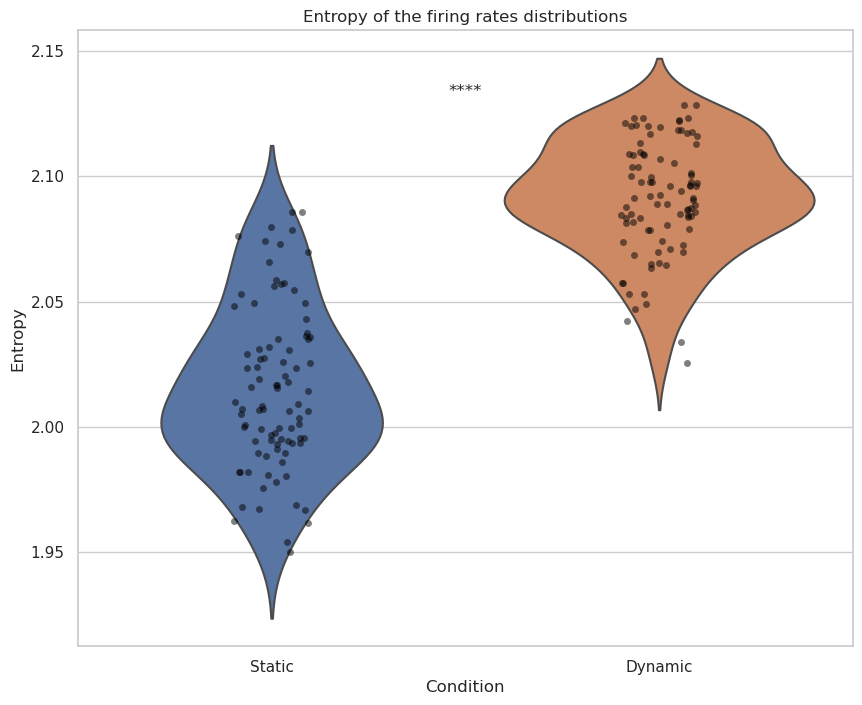

: 

In [39]:
# Plot STRIP plots comparing the entropies of the two conditions
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
data = pd.DataFrame({'Entropy': np.concatenate((entropies_stat, entropies_dyn)), 'Condition': ['Static']*params['N'] + ['Dynamic']*params['N']})
plt.figure(figsize=(10,8))
# Make a violing plot that also shows a stripplot
sns.stripplot(x='Condition', y='Entropy', data=data, jitter=True, color='black', alpha=0.5)
sns.violinplot(x='Condition', y='Entropy', data=data, inner=None)

# Add paired test to see if distrivutions are different
_, p = ks_2samp(entropies_stat, entropies_dyn)
if p < 0.05:
    # Make a star indicating there is isgnificant difference
    plt.text(0.5, 0.9, f'****', ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel('Condition')
plt.ylabel('Entropy')
plt.title('Entropy of the firing rates distributions')
plt.show()
